<p float="center">
  <img src="images/horizontal.png" alt="Coiled logo" width="415" hspace="10"/>
  <img src="images/dask_horizontal_no_pad.svg" alt="Dask logo" width="200" hspace="10" />
</p>

# Parallelize code with `dask.delayed`

*The material in this notebook is based on the open-source content from [Dask's tutorial repository](https://github.com/dask/dask-tutorial). Why? Because they did it so well. Thank you, Dask contributors!*

So you have a project or codebase that uses for-loop style code. That's easily fixable! **In this notebook, we'll parallelize code with Dask and `dask.delayed()`**. Here's the plan:

- Create a Dask Client to execute code in parallel
- Do work "normally" (i.e., sequentially) to see what it looks and feels like
- Parallelize with the `dask.delayed` decorator
- Step back and debrief on what just happened
- Parallelize a for loop
- Parallelize a for loop with control flow
- Parallelize a Pandas groupby reduction

Using `dask.delayed()` is a simple way to use Dask to parallelize existing codebases or build [complex systems](https://blog.dask.org/2018/02/09/credit-models-with-dask). Learning these basics of parallelization in this notebook will also help us when parallelizing complex systems like machine learning models in the future.

*A bit about me:* I'm Hugo Bowne-Anderson, Head of Data Science Evangelism and Marketing at [Coiled](coiled.io/). We build products that bring the power of scalable data science and machine learning to you, such as single-click hosted clusters on the cloud. We want to take the DevOps out of data science so you can get back to your real job. If you're interested in taking Coiled for a test drive, you can sign up for our [free Beta here](beta.coiled.io/).

## 1. Creating a Dask Client

Dask has several ways of executing code in parallel. We'll use the distributed scheduler by creating a `dask.distributed.Client`, which will provide us with some nice diagnostics.

In [2]:
from dask.distributed import Client

client = Client(n_workers=4)

/Users/hugobowne-anderson/opt/anaconda3/envs/data-science-at-scale/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55629 instead
  warnings.warn(


## 2. Doing work "normally"

First let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally.

Later, we'll parallelize this code.

In [3]:
client.dashboard_link

'http://127.0.0.1:55629/status'

In [4]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

We time the execution of this normal code using the `%%time` magic, which is a special Jupyter Notebook function.

In [5]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 481 ms, sys: 104 ms, total: 585 ms
Wall time: 3.01 s


## 3. Parallelizing with the `dask.delayed` decorator

Those two increment calls *could* be called in parallel, because they are totally independent of one-another.

We'll transform the `inc` and `add` functions using the `dask.delayed` function. When we call the delayed version by passing the arguments, exactly as before, but the original function isn't actually called yet -- this is why the cell execution finishes very quickly.
Instead, a *delayed object* is made, which keeps track of the function to call and the arguments to pass to it.


In [6]:
from dask import delayed

In [7]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 1.29 ms, sys: 917 µs, total: 2.21 ms
Wall time: 1.51 ms


This ran immediately, since nothing has really happened yet.

To get the result, we call `.compute()`. Note how this runs faster than the original code.

In [8]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 316 ms, sys: 62.8 ms, total: 379 ms
Wall time: 2.05 s


5

## 4. What just happened?

The `z` object is a lazy `Delayed` object.  This object holds everything we need to compute the final result, including references to all of the functions that are required and their inputs and relationship to one-another.  We can evaluate the result with `.compute()` as above or we can visualize the task graph for this value with `.visualize()`.

In [9]:
z

Delayed('add-9968fd71-f40f-4bdd-ba88-710716f329db')

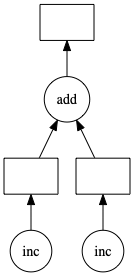

In [10]:
# Look at the task graph for `z`
z.visualize()

Notice that this includes the names of the functions from before, and the logical flow of the outputs of the `inc` functions to the inputs of `add`.

## 5. Parallelizing a for loop

`for` loops are one of the most common things that we want to parallelize.  We can use `dask.delayed` on `inc` and `sum` to parallelize the computation below:

In [11]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

Here is the sequential code:

In [12]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 1.27 s, sys: 282 ms, total: 1.55 s
Wall time: 8.03 s


In [13]:
total

44

And here is the parallelized code with `dask.delayed`:

In [15]:
%%time
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed

Before computing: Delayed('sum-9ca5bf16-17f2-4558-a6f0-be730fbd8d4d')
After computing : 44
CPU times: user 177 ms, sys: 38.9 ms, total: 216 ms
Wall time: 1.07 s


**Recap:** We

* decorated the `inc` function with `dask.delayed`
* decorated the `sum` function with `dask.delayed`

with the end result of parallelizing a for loop.

## 6. Parallelizing a for-loop code with control flow

Often we want to delay only *some* functions, running a few of them immediately.  This is especially helpful when those functions are fast and help us to determine what other slower functions we should call.  This decision, to delay or not to delay, is usually where we need to be thoughtful when using `dask.delayed`.

In the example below we iterate through a list of inputs.  If that input is even then we want to call `inc`.  If the input is odd then we want to call `double`.  This `is_even` decision to call `inc` or `double` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [16]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Here is the sequential code:

In [17]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

90
CPU times: user 1.54 s, sys: 336 ms, total: 1.87 s
Wall time: 10 s


And here is the parallelized code with `dask.delayed`:

In [18]:
%%time
# Parallel code

results = []
for x in data:
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

CPU times: user 5.34 ms, sys: 3.09 ms, total: 8.43 ms
Wall time: 5.76 ms


In [19]:
%time total.compute()

CPU times: user 351 ms, sys: 66.2 ms, total: 418 ms
Wall time: 2.05 s


90

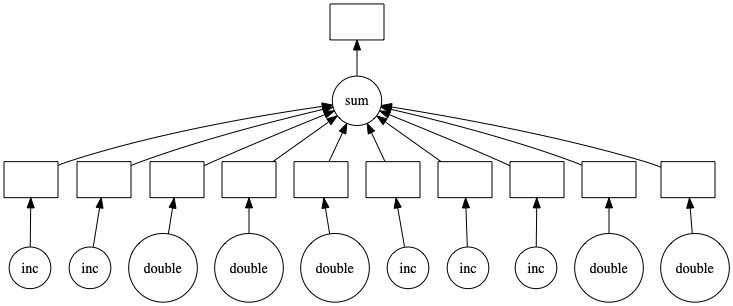

In [20]:
total.visualize()

**Recap:** We

* decorated the `double` function with `dask.delayed`
* decorated the `inc` function with `dask.delayed`
* decorated the `sum` function with `dask.delayed`

with the end result of parallelizing a for loop with control flow.

## 7. Parallelizing a Pandas Groupby Reduction

In this example we'll read several CSV files and perform a groupby operation in parallel.  We are given sequential code to do this and parallelize it with `dask.delayed`.

The computation we will parallelize is to compute the mean departure delay per airport from some historical flight data.  We will do this by using `dask.delayed` together with `pandas`.  In a future section we will do this same exercise with `dask.dataframe`.

Here's the plan:

* Create data.
* Inspect data.
* Read one file with `pandas.read_csv` and compute mean departure delay.
* Read the sequential code implementation of calculating mean departure delay per airport.
* Parallelize that sequential code.

#### Create data

In `prep.py`, code exists that preps some data for us. We'll run it.

This downloads and extracts some historical flight data for flights out of NYC between 1990 and 2000. The data is originally from [here](http://stat-computing.org/dataexpo/2009/the-data.html).

In [21]:
%run prep.py -d flights

ModuleNotFoundError: No module named 'accounts'

#### Inspect data

In [ ]:
import os
sorted(os.listdir(os.path.join('data', 'nycflights')))

#### Read one file with `pandas.read_csv` and compute mean departure delay

In [ ]:
import pandas as pd
df = pd.read_csv(os.path.join('data', 'nycflights', '1990.csv'))
df.head()

In [ ]:
# What is the schema?
df.dtypes

In [ ]:
# What originating airports are in the data?
df.Origin.unique()

In [ ]:
# Mean departure delay per-airport for one year
df.groupby('Origin').DepDelay.mean()

#### Sequential code: Mean Departure Delay Per Airport

The above cell computes the mean departure delay per-airport for one year. Here we expand that to all years using a sequential for loop.

In [ ]:
from glob import glob
filenames = sorted(glob(os.path.join('data', 'nycflights', '*.csv')))

In [ ]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

In [ ]:
mean

#### To parallelize the code above

To parallelize the above code with `dask.delayed`, there are a few extra things we will need to be aware of:

1.  Methods and attribute access on delayed objects work automatically, so if you have a delayed object you can perform normal arithmetic, slicing, and method calls on it and it will produce the correct delayed calls.

    ```python
    x = delayed(np.arange)(10)
    y = (x + 1)[::2].sum()  # everything here was delayed
    ```
2.  Calling the `.compute()` method works well when you have a single output.  When you have multiple outputs you might want to use the `dask.compute` function:

    ```python
    >>> from dask import compute
    >>> x = delayed(np.arange)(10)
    >>> y = x ** 2
    >>> min_, max_ = compute(y.min(), y.max())
    >>> min_, max_
    (0, 81)
    ```
    
    This way Dask can share the intermediate values (like `y = x**2`)
    
Here's what one version of a parallelized solution looks like:

In [ ]:
from dask import compute

In [ ]:
%%time

# This is just one possible solution, there are
# several ways to do this using `delayed`

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
sums, counts = compute(sums, counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

In [ ]:
# ensure the results still match
mean

For this solution, note how the only bit of code we had to decorate with `dask.delayed` was `pd.read_csv`. We just parallelized a Pandas groupby reduction!

## Close the Client

As always, we make sure to close our client.

In [ ]:
client.close()

**Recap:** In this notebook, we

- created a Dask Client to execute code in parallel.
- did work "normally" (i.e., sequentially) to see what it looks and feels like.
- parallelized with the `dask.delayed` decorator.
- stepped back and debriefed on what just happened.
- parallelized a for loop.
- parallelized a for loop with control flow.
- parallelized a Pandas groupby reduction.

<hr>

For more `dask.delayed()` resources:

* [Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
* [Delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU)
* [Delayed API](https://docs.dask.org/en/latest/delayed-api.html)
* [Delayed examples](https://examples.dask.org/delayed.html)
* [Delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html)